# 0 - IMPORTS

In [99]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import datetime
import matplotlib.gridspec as GridSpec
import xgboost as xgb
import random
import warnings
import pickle

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from tabulate import tabulate
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## 0.1 Helper Functions

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
     
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/ (min(kcorr-1,rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))


def ml_error( model_name, y, yhat):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mean_squared_error(y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE':mae,
                         'MAPE': mape,
                         'RMSE':rmse}, index=[0])

def cross_validation (x_training, kfold, model_name, model, verbose=False):


    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
    
        #training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance

        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
    
        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({ 'Model Name': model_name,
                         'MAE CV': np.round( np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round( np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round( np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round( np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round( np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round( np.std(rmse_list), 2).astype(str)}, index=[0])



sns.set_theme()
pd.set_option('display.float_format', lambda x: '%.5f' % x)
warnings.filterwarnings('ignore')



## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1 - DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()
df1

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00000,11.00000,2007.00000,1,13.00000,2010.00000,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00000,12.00000,2006.00000,1,14.00000,2011.00000,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00000,9.00000,2009.00000,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00000,4.00000,2015.00000,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.00000,6.00000,2014.00000,1,31.00000,2013.00000,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.00000,4.00000,2006.00000,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.00000,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.00000,NaN,NaN,0,NaN,NaN,NaN


## 1.1 Rename Columns 

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2 Data Dimension

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA's

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA's

In [9]:
#competition_distance (descobri um valor máximo para o compedidor, estrapolei o valor para ser desconsiderado e apliquei este mesmo valor desconsiderado nas linhas onde não haviam este tipo de transformação)
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x) else x) 

#competition_open_since_month (caso não exista uma data de abertura do competidor mais proximo, iremos assumir que esta data é o mês de venda)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year   (mesma ideia de cima, vamos entender o porquê mais a frente)  
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
    
#promo2_since_week (mesma ideia de cima, vamos entender o porquê mais a frente) 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year (mesma ideia de cima, vamos entender o porquê mais a frente)

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#transformando os NA's da coluna 'promo_interval' em 0:

df1['promo_interval'].fillna(0, inplace=True)

#Mapeando o mês, de acordo com as atribuições do dicionário month_map, atribuimos a colina 'month_map' os meses respectivos ao mês de venda

df1['month_map'] = df1['date'].dt.month.map(month_map)

#Se o mês correspondente a coluna 'month_map' estiver em algum dos meses listados na coluna 'promo_interval', retornar 1, else retornar zero

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.6 Change dtypes

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
# Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion Metrics - min, max, std, range, kurtosis, skew

dm1 = pd.DataFrame(num_attributes.apply(np.min)).T
dm2 = pd.DataFrame(num_attributes.apply(np.max)).T
dm3 = pd.DataFrame(num_attributes.apply(np.std)).T
dm4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dm5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dm6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenando para melhorar a visualização





In [14]:
m = pd.concat([dm1,dm2,dm4,ct1,ct2,dm3,dm5,dm6]).T.reset_index()

In [15]:
m.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

In [16]:
m

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00000,1115.00000,1114.00000,558.42973,558.00000,321.90849,-0.00095,-1.20052
1,day_of_week,1.00000,7.00000,6.00000,3.99834,4.00000,1.99739,0.00159,-1.24687
2,sales,0.00000,41551.00000,41551.00000,5773.81897,5744.00000,3849.92428,0.64146,1.77837
3,customers,0.00000,7388.00000,7388.00000,633.14595,609.00000,464.41151,1.59865,7.09177
4,open,0.00000,1.00000,1.00000,0.83011,1.00000,0.37554,-1.75804,1.09072
5,promo,0.00000,1.00000,1.00000,0.38151,0.00000,0.48576,0.48784,-1.76202
6,school_holiday,0.00000,1.00000,1.00000,0.17865,0.00000,0.38306,1.67784,0.81515
7,competition_distance,20.00000,200000.00000,199980.00000,5935.44268,2330.00000,12547.64683,10.24234,147.78971
8,competition_open_since_month,1.00000,12.00000,11.00000,6.78685,7.00000,3.31109,-0.04208,-1.23261
9,competition_open_since_year,1900.00000,2015.00000,115.00000,2010.32484,2012.00000,5.51559,-7.23566,124.07130


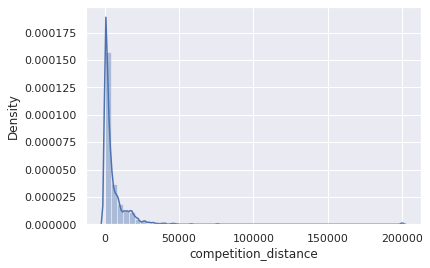

In [17]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

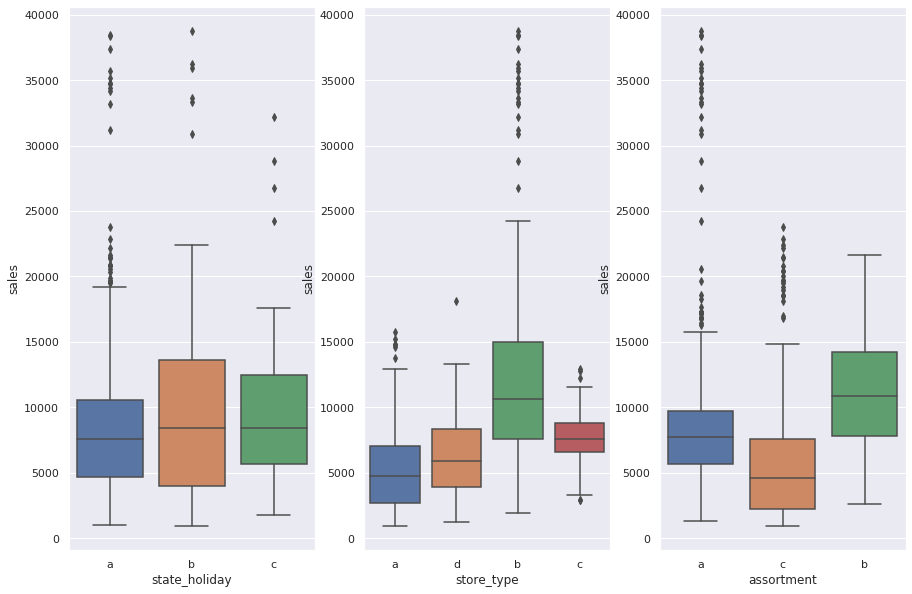

In [19]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]
sns.set_theme()
sns.set(rc = {'figure.figsize':(15,10)})
plt.subplot(1, 3, 1)
sns.boxplot (x='state_holiday',y='sales',data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot (x='store_type',y='sales',data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot (x='assortment',y='sales',data=aux1)

# 2 - FEATURE ENGINEERING

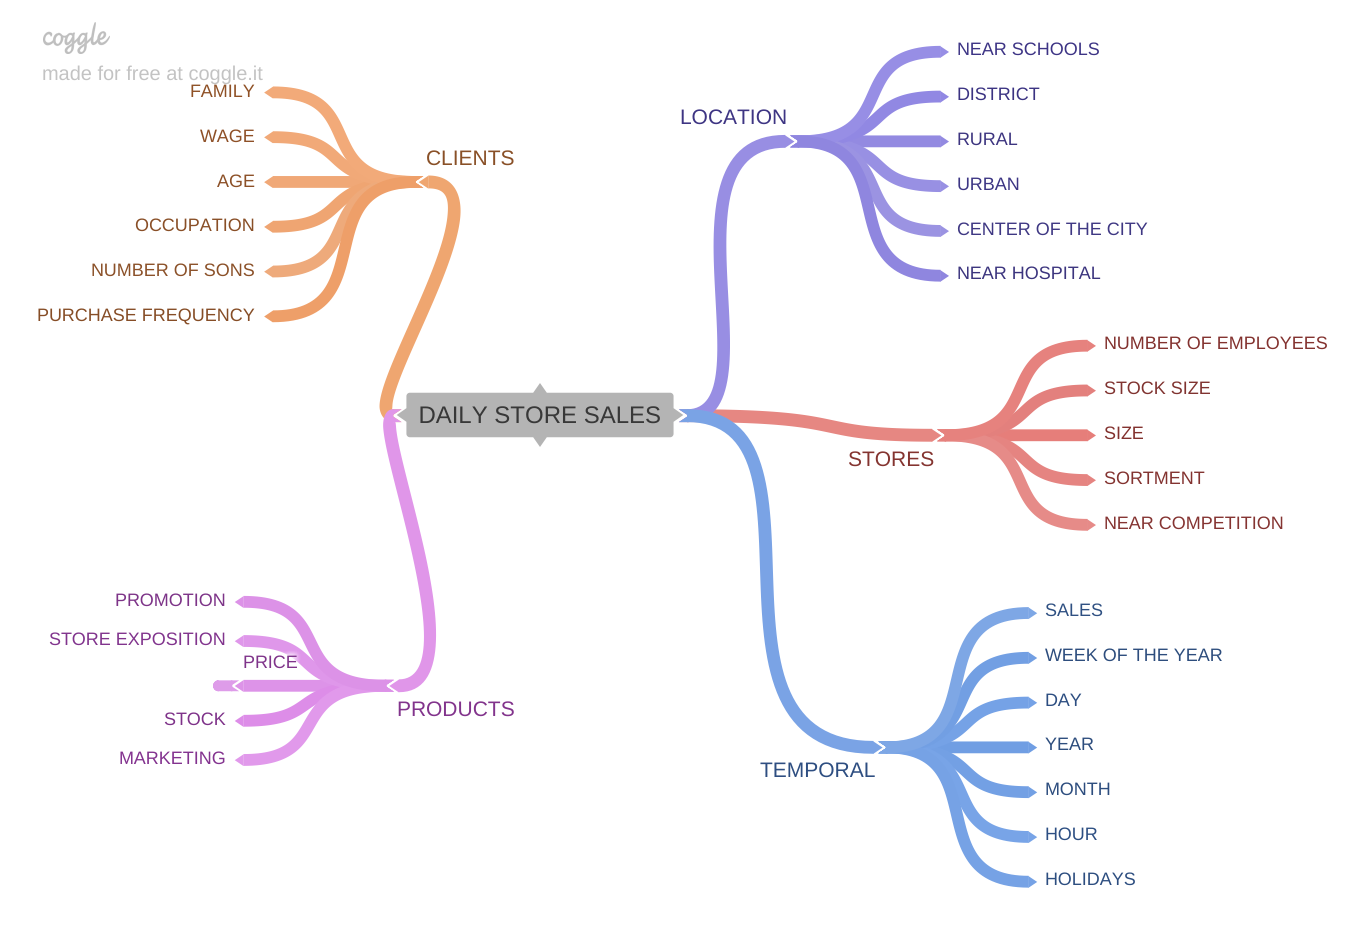

In [20]:
Image('images/MindMapHyphotesis.png')

## 2.1 Hypothesis Creation

In [21]:
df2 = df1.copy()

In [22]:
df2[df2['state_holiday'] == 'christmas']

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo


### 2.1.1 Store Hypothesis

In [23]:
#1 Lojas que investem mais em marketing deveriam vender mais
#2 Lojas com maior exposição de produto deveriam vender mais
#3 Lojas com produtos com preço menor deveriam vender mais
#5 Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais
#6 Lojas com promoçoes ativas por mais tempo deveriam vender mais
#7 Lojas com mais dias de promoção deveriam vender mais
#8 Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.2 Product Hypothesis

In [24]:
# 1 Lojas com número maior de funcionários deveriam vender mais
#2 Lojas com maior capacidade de estoque deveriam vender mais
#3 Lojas com maior porte deveriam vender mais
#4 Lojas com maior sortimentos deveriam vender mais
#5 Lojas com competidores mais próximos deveriam vender menos
#6 Lojas com competidores a mais tempo deveriam vender mais

### 2.1.3 Time Hypothesis

In [25]:
#1 Lojas abertas durantes o feriado de Natal deveriam vender mais 
#2 Lojas deveriam vender mais ao longo dos anos
#3 Lojas deveriam vender mais no segundo semestre do ano
#4 Lojas deveriam vender mais depois do dia 10 de cada mês
#5 Lojas deveriam vender menos aos finais de semana
#6 Lojas deveriam vender menos durante os feriados escolares

## 2.2 Lista final de hipóteses (Separando o que eu tenho dado para testar as hipoteses)

In [26]:
# 1 Lojas com maior sortimentos deveriam vender mais
#2 Lojas com competidores mais proximos deveriam vender menos
#3 Lojas com competidores a mais tempo deveriam vender mais
#4 Lojas com promoçoes ativas por mais tempo deveriam vender mais
#5 Lojas com mais dias de promoção deveriam vender mais
#6 Lojas com mais promoçoes consecutivas deveriam vender mais
#7 Lojas abertas durantes o feriado de Natal deveriam vender mais
#8 Lojas deveriam vender mais ao longo dos anos
#9 Lojas deveriam vender mais no segundo semestre do ano
#10 Lojas deveriam vender mais depois do dia 10 de cada mês
#11 Lojas deveriam vender menos aos finais de semana
#12 Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

In [27]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week year
df2['week_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since

df2['competition_since'] = df2.apply(lambda x : datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


#assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended' )

#state_holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day') 

# 3 - VARIABLES FILTERING

In [28]:
df3 = df2.copy()


## 3.1 Filtragem das linhas

In [29]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]


## 3.2 Filtragem das colunas

In [30]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [31]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4 - EXPLORATORY DATA ANALYSIS

In [32]:
df4 = df3.copy()

num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 4.1 Análise Univariada

### 4.1.1 Response Variable

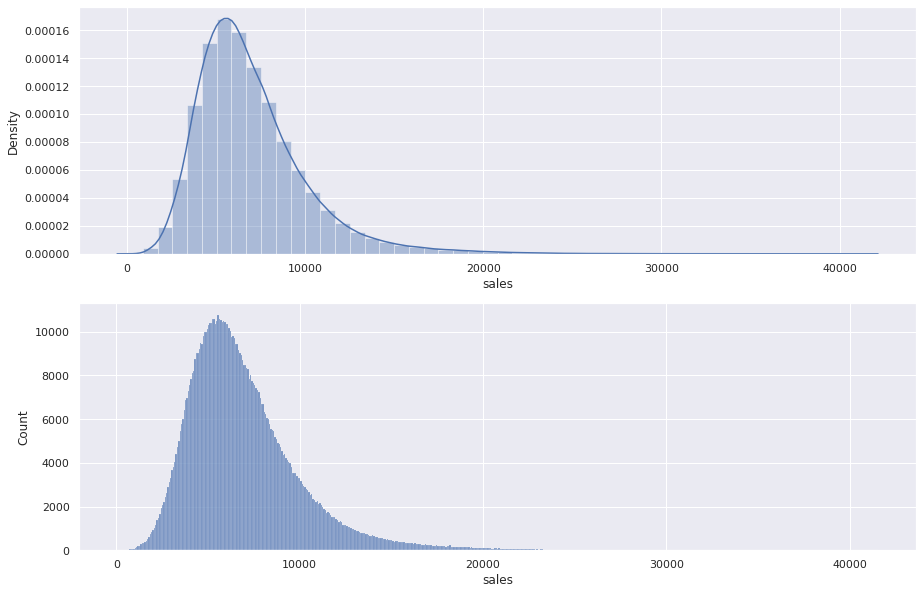

In [33]:

plt.subplot(2,1,1)
sns.distplot(df4['sales']);

plt.subplot(2,1,2)
sns.histplot(df4['sales']);

In [34]:
df4[['store','sales']].groupby('store').sum().reset_index()

,store,sales
0,1,3716854
1,2,3883858
2,3,5408261
3,4,7556507
4,5,3642818
...,...,...
1110,1111,4091076
1111,1112,7974294
1112,1113,5196242
1113,1114,16202585


### 4.1.2 Numerical Variable


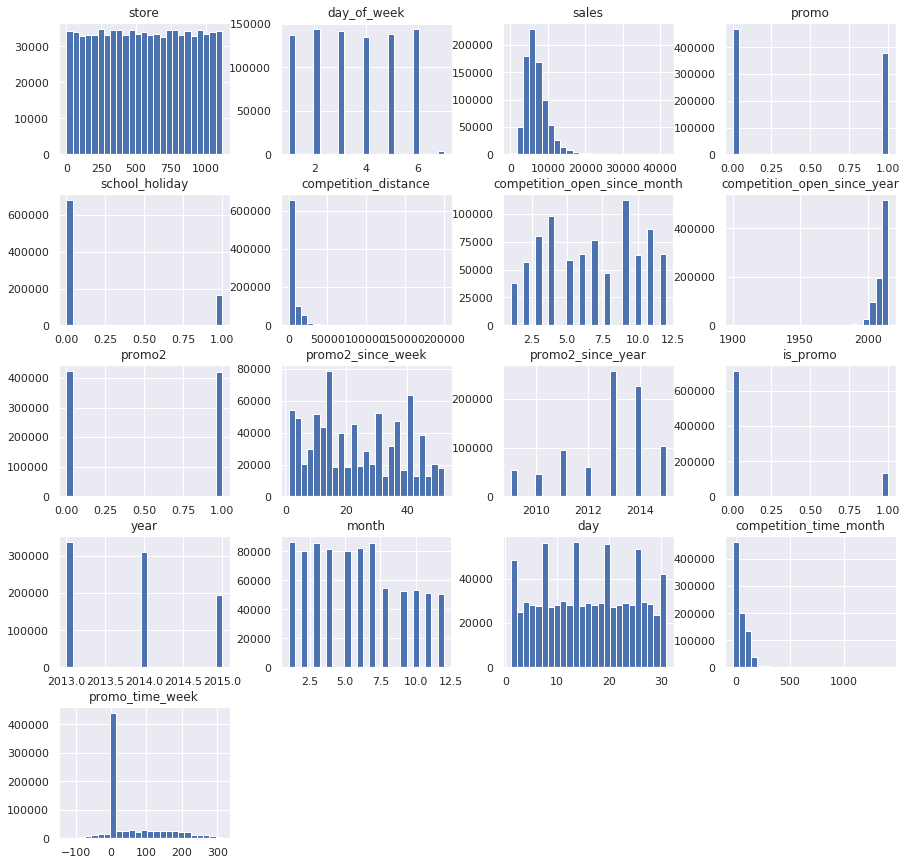

In [35]:
sns.set(rc = {'figure.figsize':(15,15)})
num_attributes.hist( bins=25);

### 4.1.3 Categorical Variable

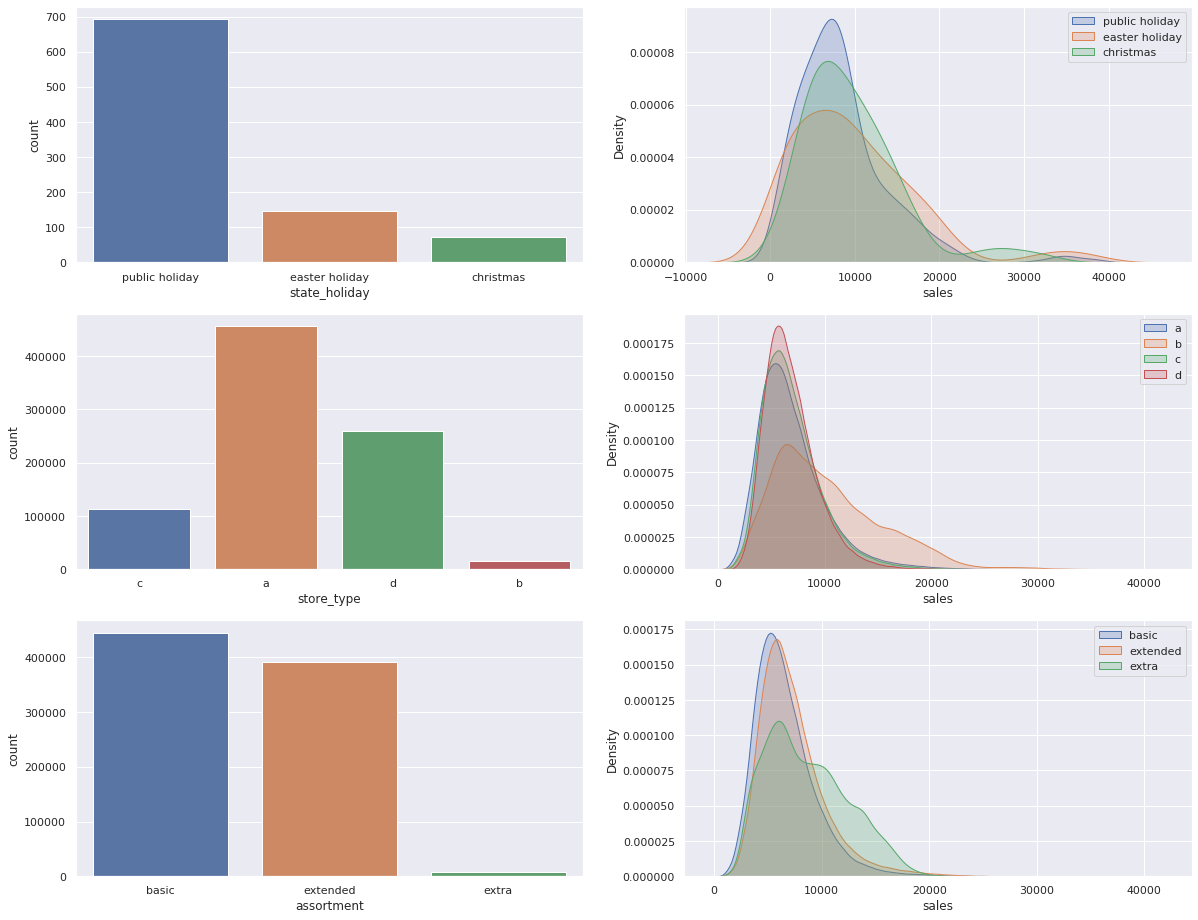

In [36]:
#state_holiday
sns.set(rc = {'figure.figsize':(20,16)})

plt.subplot(3,2, 1)
a = df4[df4['state_holiday'] != 'regular day']
sns.countplot(x=a['state_holiday']);

plt.subplot(3,2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label='public holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter holiday']['sales'], label='easter holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend();

#store_type
plt.subplot(3,2, 3)
sns.countplot(x=df4['store_type']);

plt.subplot(3,2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend();

#assortment
plt.subplot(3,2, 5)
sns.countplot(x=df4['assortment']);

plt.subplot(3,2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend();


## 4.2 Análise Bivariada

### 1 Lojas com maior sortimentos deveriam vender mais
### FALSE: LOJAS COM MAIOR SORTIMENTO VENDEM MENOS

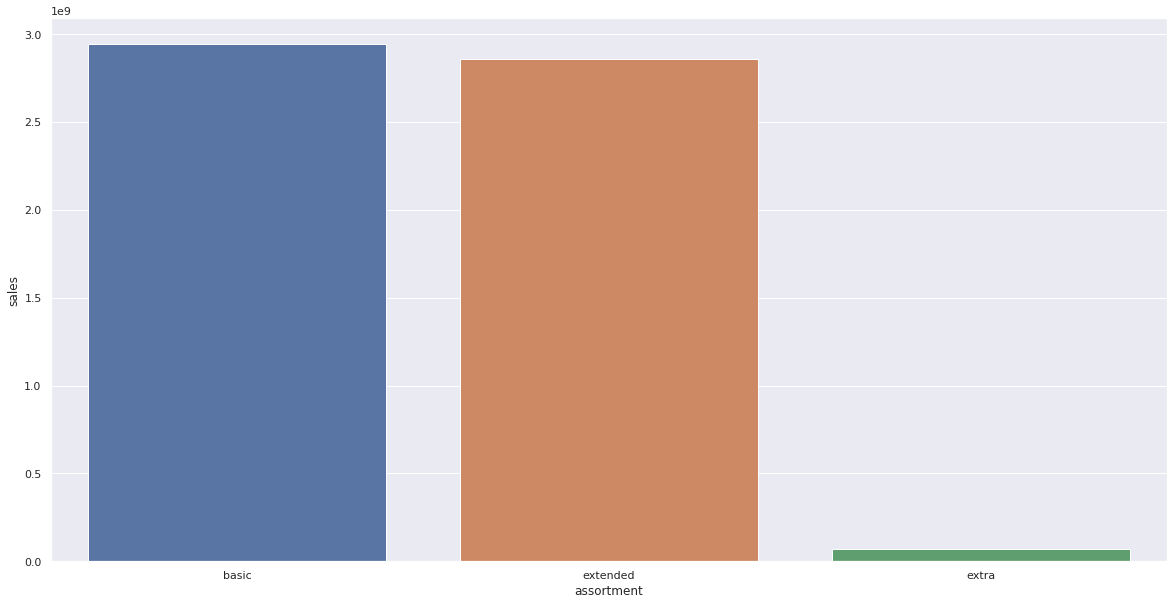

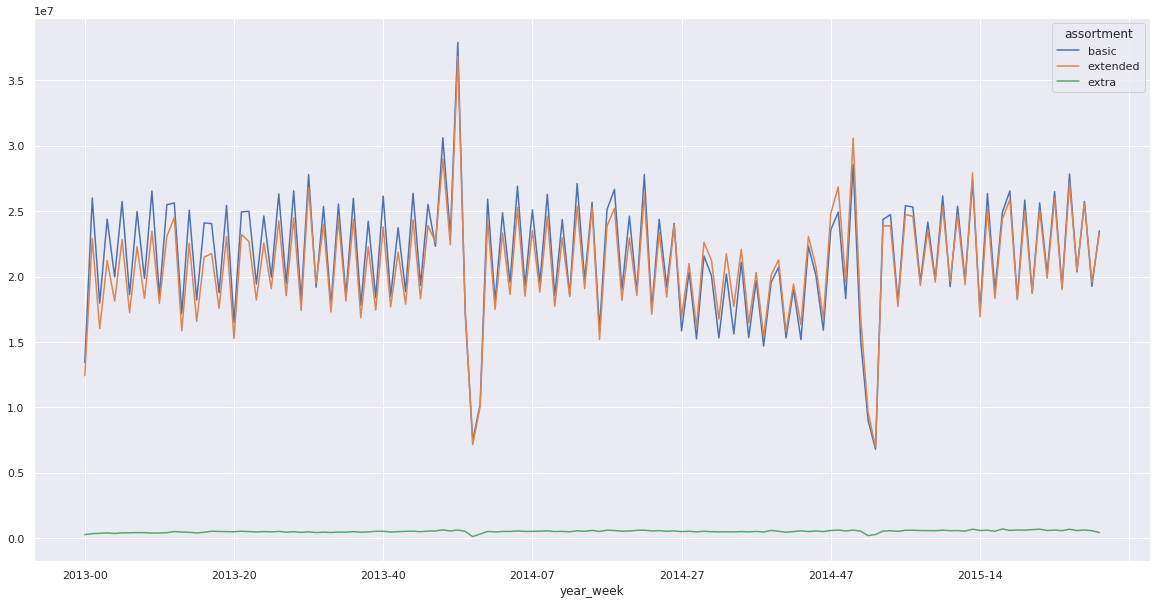

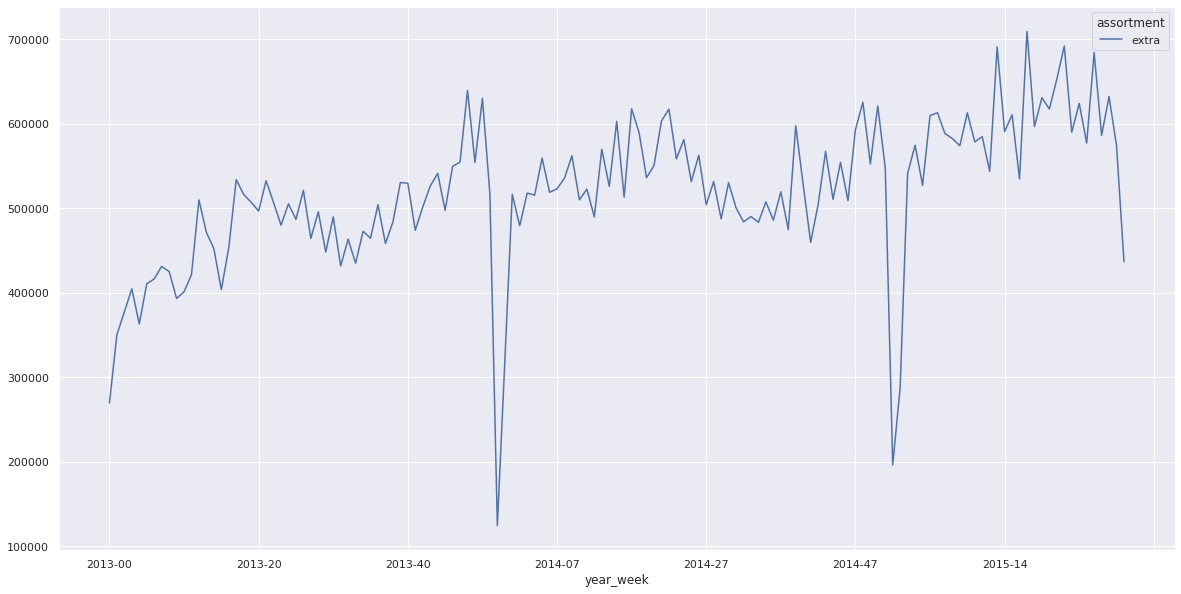

In [37]:
sns.set(rc = {'figure.figsize':(20,10)})


aux1 = df4[['sales','assortment']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','sales','assortment']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### 2 Lojas com competidores mais proximos deveriam vender menos
### FALSE: LOJAS COM COMPETIDORES MAIS PROXIMOS VENDEM MAIS E NÃO MENOS

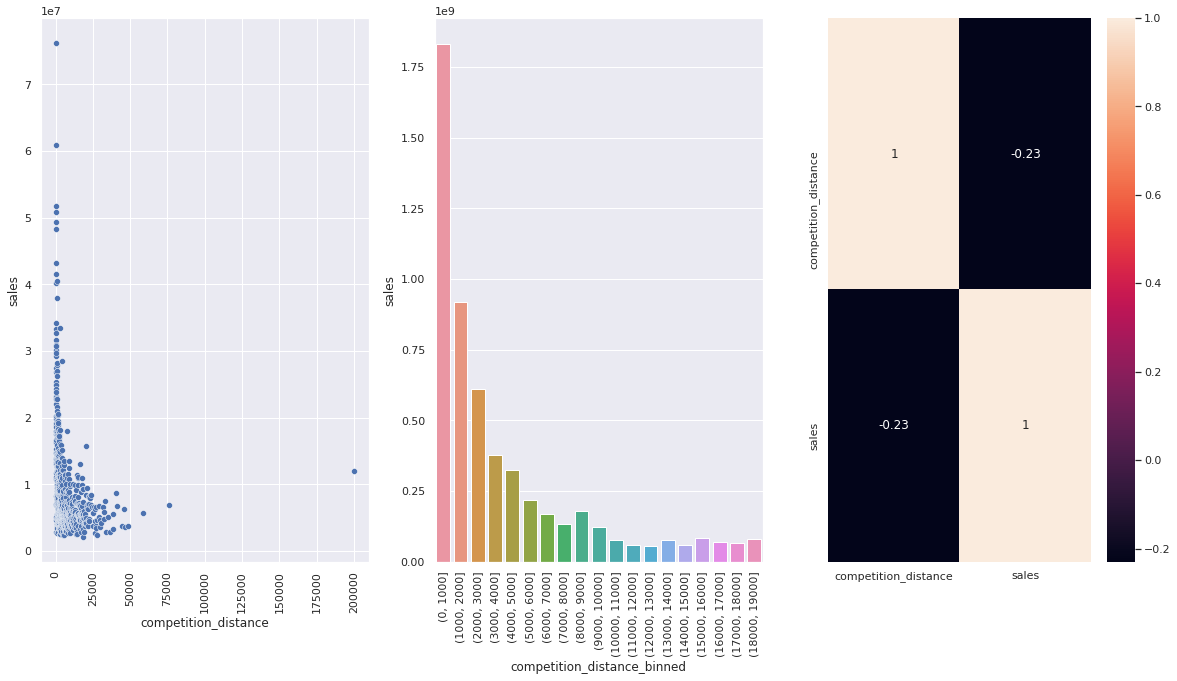

In [38]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1);
plt.xticks( rotation=90)

plt.subplot(1,3,2)
bins = list( np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90)

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)


### 3 Lojas com competidores a mais tempo deveriam vender mais
### FALSE: LOJAS COM COMPETIDORES A MAIS TEMPO VENDEM MENOS

In [39]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

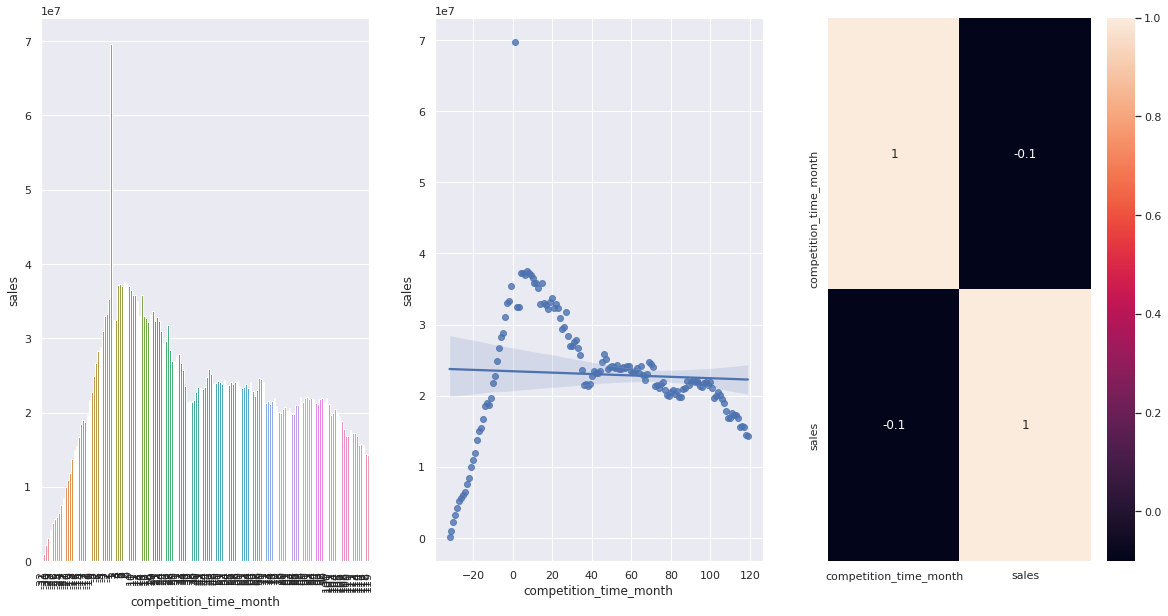

In [40]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <120) & (aux1['competition_time_month']!=0)]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2)


plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method='pearson'),annot=True);


### 4 Lojas com promoçoes ativas por mais tempo deveriam vender mais
### FALSE: LOJAS COM PROMOÇÕES ATIVAS POR MAIS TEMPO VENEM MENOS DEPOIS DE UM CERTO PERIODO

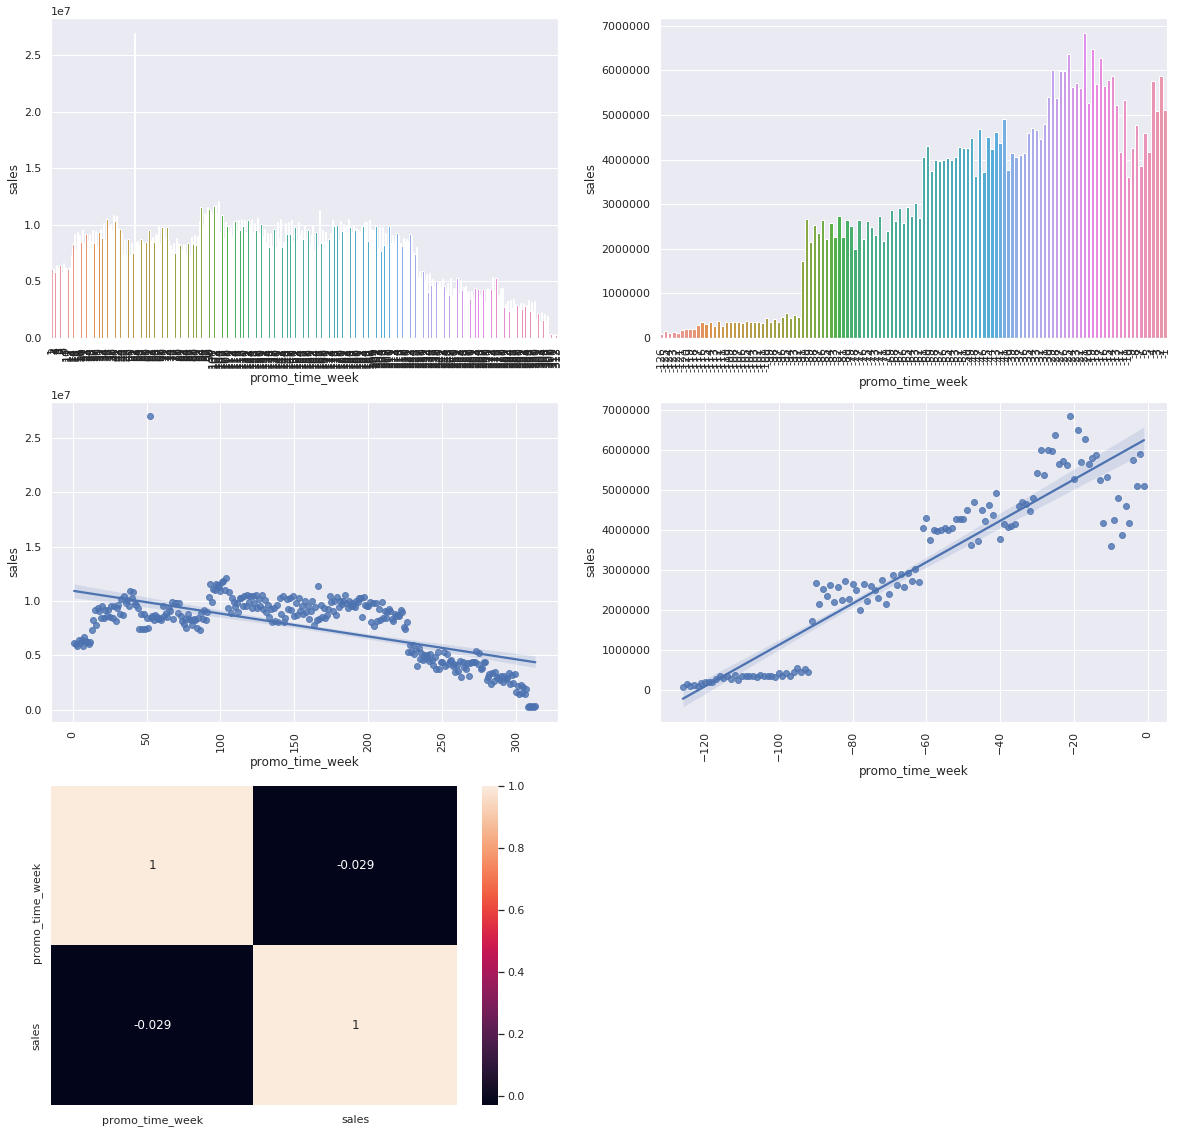

In [41]:
# Se promo_time_week for negativo promoção tradicional e se for positivo estou na promoção extendida

sns.set(rc = {'figure.figsize':(20,20)})

aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
aux2 = aux1[aux1['promo_time_week'] > 0]
aux3 = aux1[aux1['promo_time_week'] < 0]


plt.subplot(3,2,1)
sns.barplot(x='promo_time_week',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(3,2,2)
sns.barplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(3,2,3)
sns.regplot(x='promo_time_week',y='sales',data=aux2);
plt.xticks(rotation=90);


plt.subplot(3,2,4)
sns.regplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

#força da correlação
plt.subplot(3,2,5)
sns.heatmap(aux1.corr(method='pearson'), annot=True);



### 5 Lojas com mais dias de promoção deveriam vender mais
### Será validado no proximo ciclo do CRISP

### 7 Lojas com mais promoçoes consecutivas deveriam vender mais
### FALSE: Lojas com mais promoções vendem menos

In [42]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


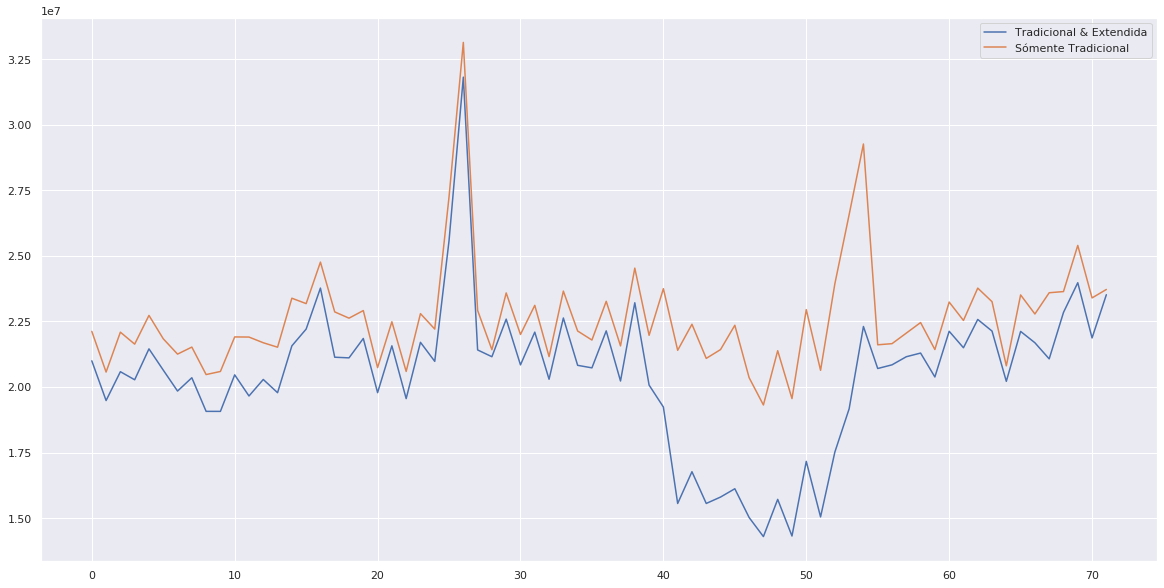

In [43]:
sns.set(rc = {'figure.figsize':(20,10)})
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Tradicional & Extendida','Sómente Tradicional']);






### 8 Lojas abertas durante o feriado de Natal deveriam vender mais
### FALSE: LOJAS VENDEM MAIS DURANTE OS FERIADOS PUBLICOS



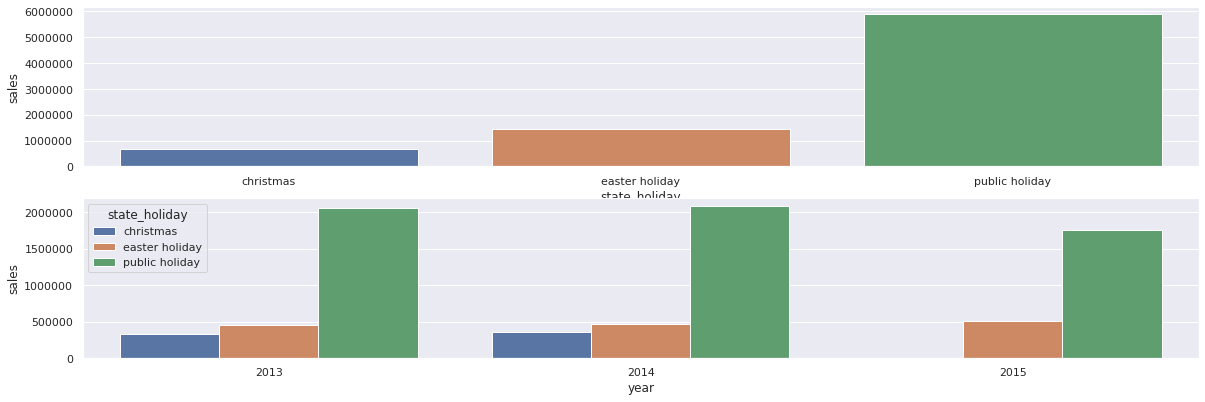

In [44]:
aux1 = df4[df4['state_holiday'] != 'regular day']
aux2 = aux1[['sales','state_holiday']].groupby('state_holiday').sum().reset_index()
aux3 = aux1[['sales','state_holiday','year']].groupby(['year','state_holiday']).sum().reset_index()

plt.subplot(3,1,1)
sns.barplot(x='state_holiday',y='sales',data=aux2);

plt.subplot(3,1,2)
sns.barplot(x='year',y='sales', hue='state_holiday',data=aux3);




### 9 Lojas deveriam vender mais ao longo dos anos
### FALSE, VENDEM MENOS AO LONGO DOS ANOS

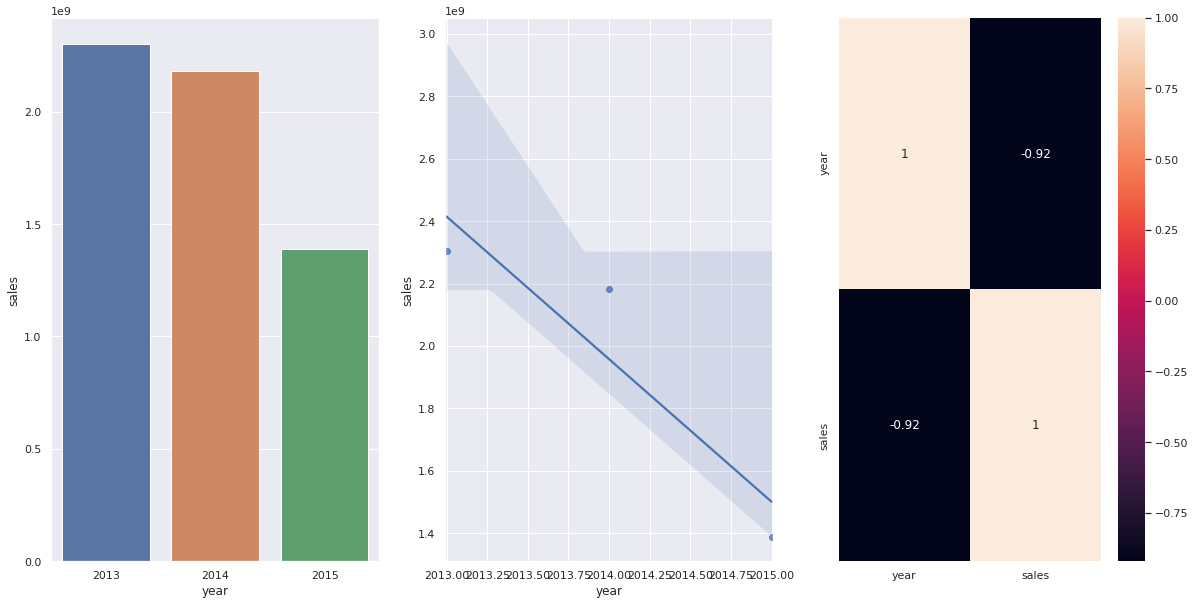

In [45]:
sns.set(rc = {'figure.figsize':(20,10)})

aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### 10 Lojas deveriam vender mais no segundo semestre do ano
### FALSA: LOJAS VENDEM MENOS NO SEGUNDO SEMESTRE DO ANO


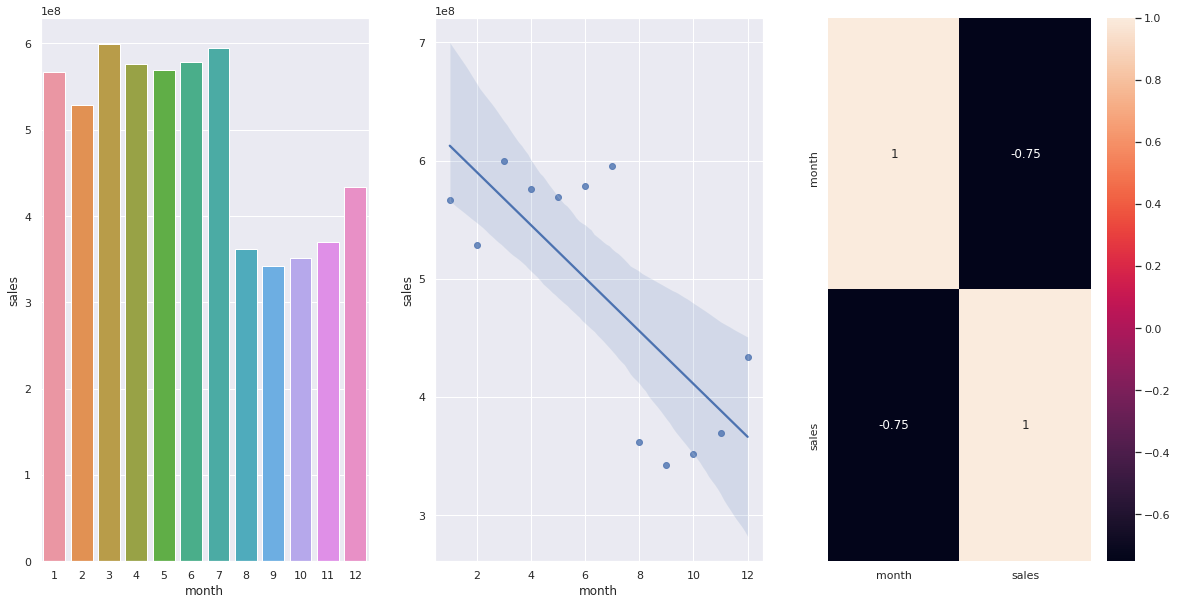

In [46]:
sns.set(rc = {'figure.figsize':(20,10)})
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### 11 Lojas deveriam vender mais depois do dia 10 de cada mês
### VERDADEIRO MAS NÃO CONCORDO

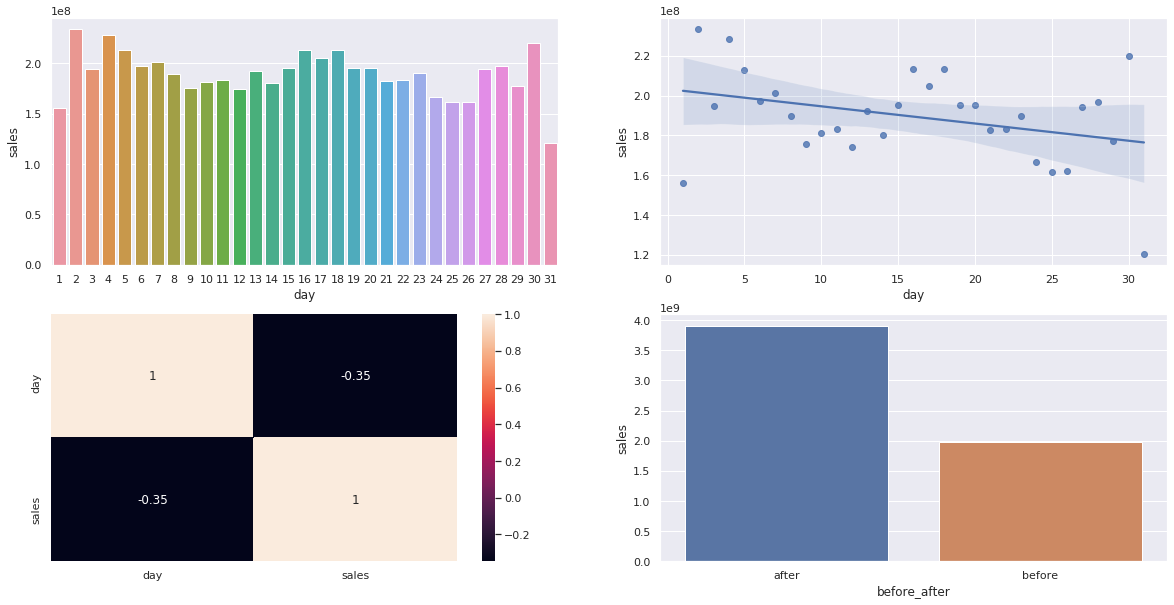

In [47]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before' if x<=10 else 'after')

aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);

### 12 Lojas deveriam vender menos aos finais de semana
### TRUE VENDEM MENOS AOS FINAIS DE SEMANA

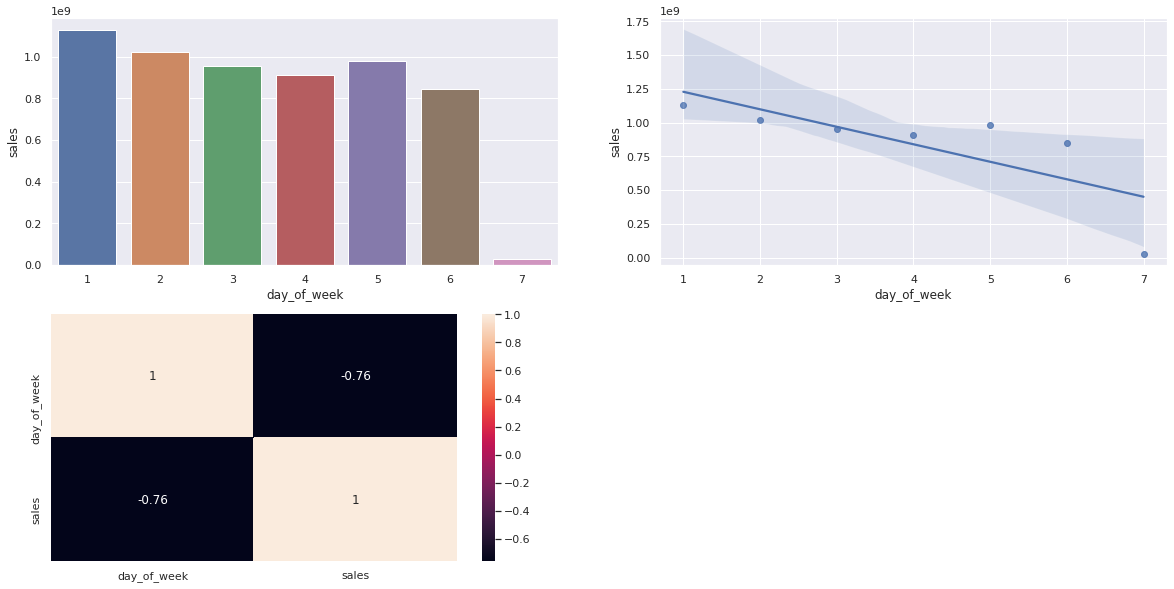

In [48]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


### 13 Lojas deveriam vender menos durante os feriados escolares
### TRUE: VENDEM MENOS, EXCETO JULHO E AGOSTO


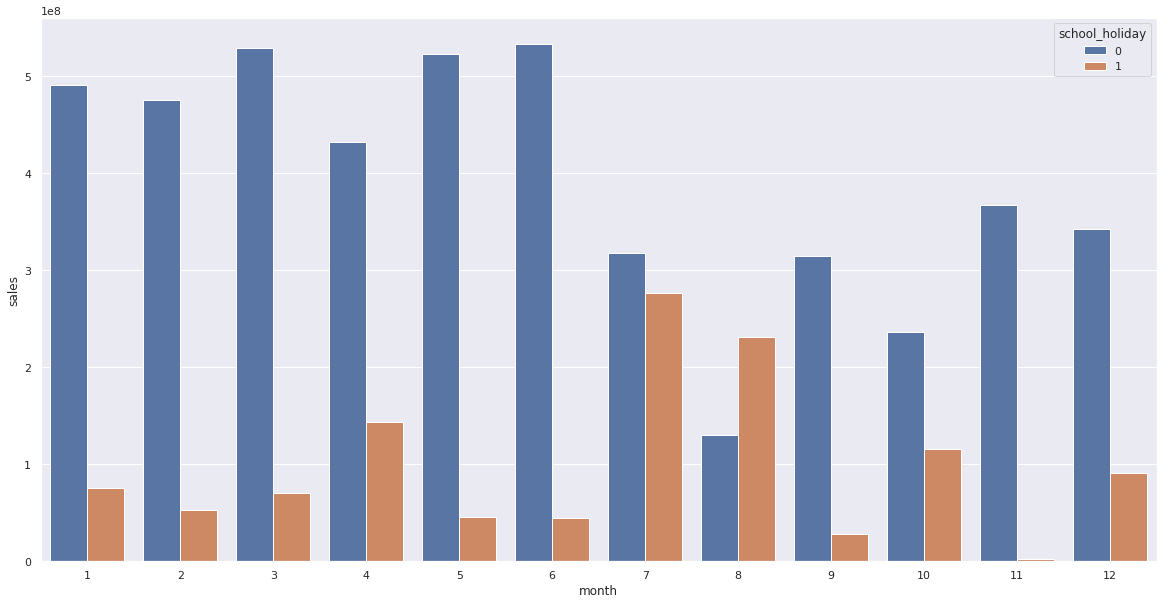

In [49]:
sns.set(rc = {'figure.figsize':(20,10)})
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux1);


In [50]:
tab = [['HIPOTESES','CONCLUSAO','RELEVANCIA'],
      ['H1','FALSA','BAIXA'],
      ['H2','FALSA','MEDIA'],
      ['H3','FALSA','MEDIA'],
      ['H4','FALSA','BAIXA'],
      ['H5','-','-'],
      ['H7','FALSA','BAIXA'],
      ['H8','FALSA','MEDIA'],
      ['H9','FALSA','ALTA'],
      ['H10','FALSA','ALTA'],
      ['H11','VERDADEIRA','ALTA'],
      ['H12','VERDADEIRA','ALTA'],
      ['H13','VERDADEIRA','BAIXA'],
      ]

print(tabulate(tab, headers='firstrow'))


HIPOTESES    CONCLUSAO    RELEVANCIA
-----------  -----------  ------------
H1           FALSA        BAIXA
H2           FALSA        MEDIA
H3           FALSA        MEDIA
H4           FALSA        BAIXA
H5           -            -
H7           FALSA        BAIXA
H8           FALSA        MEDIA
H9           FALSA        ALTA
H10          FALSA        ALTA
H11          VERDADEIRA   ALTA
H12          VERDADEIRA   ALTA
H13          VERDADEIRA   BAIXA


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

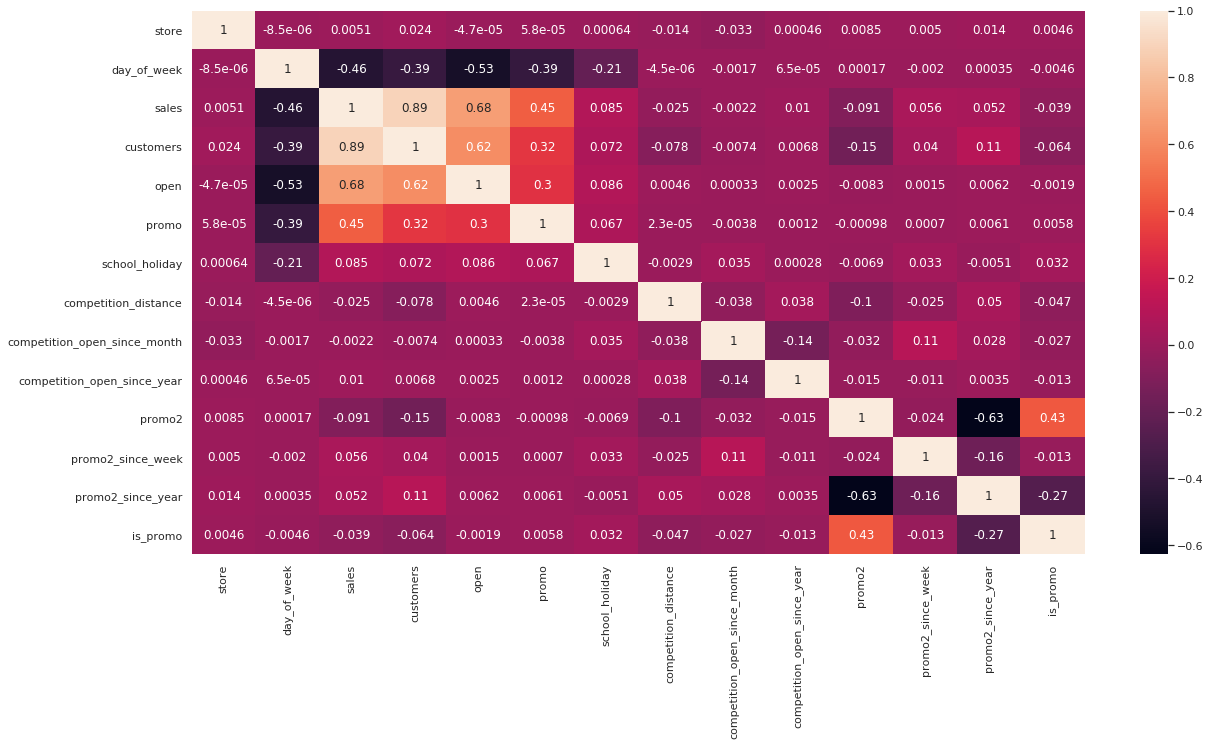

In [51]:
dff = df2.copy()

cols_drop = ['year','month','day','competition_time_month','promo_time_week']
dff = dff.drop(cols_drop, axis=1)
num_attributes = dff.select_dtypes(include=['int64','float64'])

correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

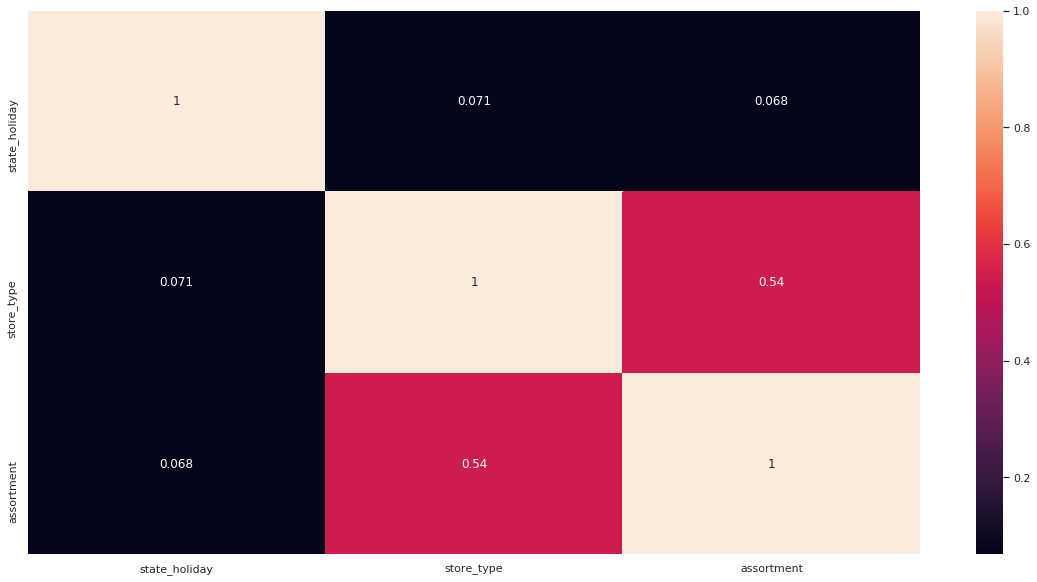

In [52]:
a = df4.select_dtypes( include='object')


#calcular o cramer V - função cramer_v em funções
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame( {'state_holiday': [a1,a2,a3],
                   'store_type': [a4,a5,a6],  
                   'assortment': [a7,a8,a9],})

d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5 - DATA PREPARATION

In [53]:
df5 = df4.copy()

## 5.1 Normalização

In [54]:
# Como não há nenhuma distribuição normal entre as variáveis numéricas, não será feita a normalização

## 5.2 Reescaling

In [55]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [56]:
# state_holiday - One hot enconding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [57]:
# Transformação Logarítmica
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Transformação de Natureza

In [58]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# week of year
df5['week_year_sin'] = df5['week_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_year_cos'] = df5['week_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# day of week
 
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

# 6 - FEATURE SELECTION

In [59]:
df6 = df5.copy()

## 6.1 Split the dataframe into train and test

In [60]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular day,month_sin,month_cos,day_sin,day_cos,week_year_sin,week_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.56865,1,1,2,1,-0.17097,9,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
1,2,5,2015-07-31,8.71029,1,1,0,1,-0.28387,11,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
2,3,5,2015-07-31,9.02582,1,1,0,1,1.90323,12,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
3,4,5,2015-07-31,9.54653,1,1,2,3,-0.27581,9,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252
4,5,5,2015-07-31,8.48115,1,1,0,1,4.44839,4,...,0,1,-0.50000,-0.86603,0.20791,0.97815,-0.56806,-0.82298,-0.97493,-0.22252


In [61]:
cols_drop = ['week_year','day','month','day_of_week','promo_since','competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [62]:
# a separação será feita da seguinte forma: da data mínima até 6 semanas antes da data máxima será o treino, o restante sera o teste

a = df6[['store','date']].groupby('store').min().reset_index()
b = df6[['store','date']].groupby('store').max().reset_index()

In [63]:
#train dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta como selecionador de variáveis

In [64]:
#training and test dataset for Boruta (transformando o df em matriz)

X_train_n = X_train.drop(['date','sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit( x_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [65]:
#cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date','sales'],axis=1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual feature selection

In [66]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_year_sin',
 'week_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

#columns to add
feat_to_add = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

#final features
#cols_selected_boruta.extend (feat_to_add)

# 7 -  MACHINE LEARNING MODELLING

In [67]:
df7 = df6.copy()

In [68]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[ cols_selected_boruta]

# Time Series Data Preparation

x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [69]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()


#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename( columns ={'sales':'predictions'})
aux1 = pd.merge (aux1,aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80035,0.45505,1835.13554


## 7.2 Linear Regressor Model

In [70]:
# model

lr = LinearRegression().fit( x_train, y_train)

# prediction
yhat_lr = lr.predict (x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.08977,0.29269,2671.04922


### 7.2.1 Linear Regression Model - Cross Validation

In [71]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model (Lasso)

In [72]:
# model

lrr = Lasso(alpha=0.01).fit( x_train, y_train)

# prediction
yhat_lrr = lrr.predict (x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.28911,2744.45174


### 7.3.1 Linear Regression Regularized Model (Lasso) - Cross Validation

In [73]:
lrr_result_cv = cross_validation(x_training,5,'Lasso',lrr,verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [74]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict( x_test )

#performance
rf_result = ml_error ('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.09839,0.09988,1009.86987


### 7.4.1 Random Forest Regressor - Cross Validation

In [75]:
rf_result_cv = cross_validation(x_training,5,'Random Forest Regressor',rf,verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [76]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.47 +/- 218.61,0.12 +/- 0.02,1257.22 +/- 319.82


## 7.5 XGBoost Regressor

In [77]:
#model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01, 
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict( x_test )

#performance
xgb_result = ml_error ('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_rf))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,679.09839,0.09988,1009.86987


### 7.5.1 XGBoost Regressor - Cross Validation


In [78]:
xgb_result_cv = cross_validation(x_training,5,'XGB Boost',model_xgb,verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [79]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Boost,1041.51 +/- 191.12,0.14 +/- 0.02,1501.83 +/- 264.5


## 7.6 Compare Model's Performance

In [80]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.09839,0.09988,1009.86987
0,XGBoost Regressor,679.09839,0.09988,1009.86987
0,Average Model,1354.80035,0.45505,1835.13554
0,Linear Regression,1867.08977,0.29269,2671.04922
0,Linear Regression - Lasso,1891.70488,0.28911,2744.45174


### 7.6.1 Single Performance

In [81]:
modelling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.47 +/- 218.61,0.12 +/- 0.02,1257.22 +/- 319.82
0,XGB Boost,1041.51 +/- 191.12,0.14 +/- 0.02,1501.83 +/- 264.5
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8 - HYPERPARAMETER FINE TUNNING

## 8.1 - Random Search

In [82]:
# param = {
#     'n_estimators':[15,17,25,30,35],
#     'eta':[0.01,0.03],
#     'max_depth':[3,5,9],
#     'subsample':[0.1,0.5,0.7],
#     'colsample_bytree':[0.3,0.7,0.9],
#     'min_child_weight':[3,8,15]
#          }
# MAX_EVAL = 2

In [83]:
# final_result = pd.DataFrame()
# for i in range(MAX_EVAL):
#     #choose values for parameters randomly:
#     hp = {k:random.sample(v,1)[0] for k, v in param.items()}
#     print(hp)
#     #model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                              n_estimators=hp['n_estimators'], 
#                              eta=hp['eta'], 
#                              max_depth=hp['max_depth'],
#                              subsample=hp['subsample'],
#                              colsample_bytee=hp['colsample_bytree'],
#                              min_child_weight=hp['min_child_weight'])

#     #performance
#     result = cross_validation (x_training,2,'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
                                 
# final_result

## 8.2 - Final Model

In [84]:
param_tunned = {
    'n_estimators':3000,
    'eta':0.03,
    'max_depth':5,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3
         }


In [85]:
#model
model_xgb_tunned = xgb.XGBRegressor( objective='reg:squarederror',
                                     n_estimators=param_tunned['n_estimators'], 
                                     eta=param_tunned['eta'], 
                                     max_depth=param_tunned['max_depth'],
                                     subsample=param_tunned['subsample'],
                                     colsample_bytee=param_tunned['colsample_bytree'],
                                     min_child_weight=param_tunned['min_child_weight']).fit(x_train,y_train)
        
#prediction

yhat_xgb_tunned = model_xgb_tunned.predict(x_test)


#performance
xgb_result_tunned = ml_error ('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tunned))
xgb_result_tunned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,667.77884,0.09752,962.38715


# 9 - ERROR TRANSLATION & INTERPRETATION

In [86]:
df9 = X_test[cols_selected_boruta_full]

# rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tunned)

## 9.1 Business Performance

In [87]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#merge of the two datasets
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]


In [88]:
df92.sort_values('MAPE',ascending=True)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1088,1089,377852.18750,377345.46034,378358.91466,506.72716,0.04901
258,259,540620.56250,539984.17558,541256.94942,636.38692,0.04987
666,667,316318.53125,315861.61494,316775.44756,456.91631,0.05243
732,733,645172.62500,644387.13345,645958.11655,785.49155,0.05444
1097,1098,186649.92188,186370.35244,186929.49131,279.56943,0.05597
...,...,...,...,...,...,...
594,595,392708.87500,389019.57406,396398.17594,3689.30094,0.25454
721,722,354602.37500,352567.06762,356637.68238,2035.30738,0.27242
875,876,202928.35938,198978.94665,206877.77210,3949.41273,0.30797
908,909,231949.89062,224194.28263,239705.49862,7755.60800,0.51875


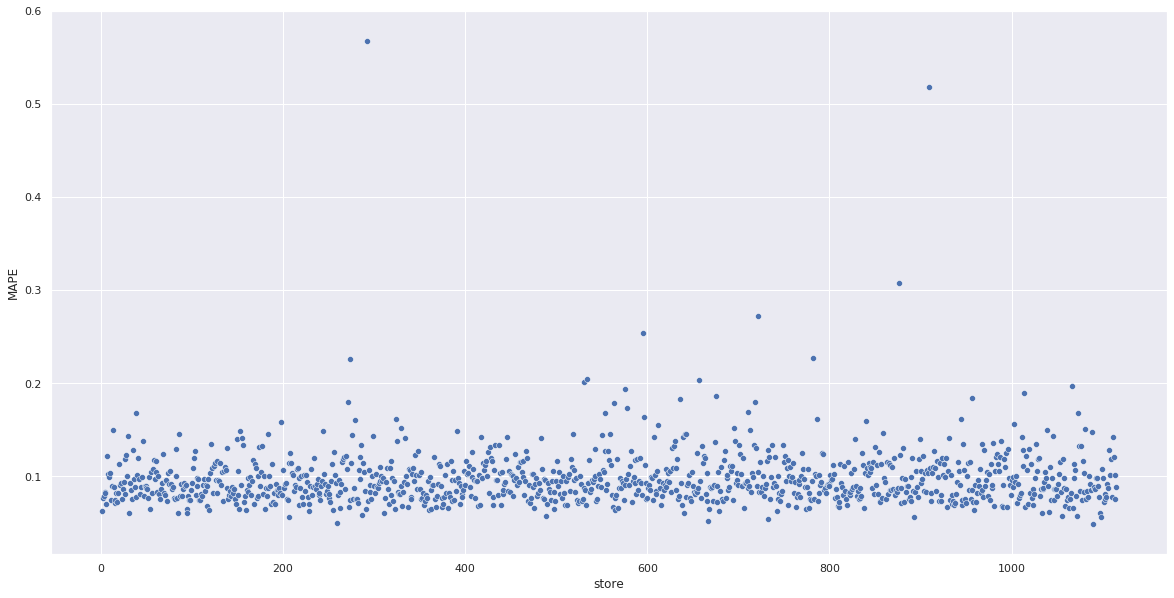

In [89]:
sns.scatterplot(x='store',y='MAPE',data=df92);

## 9.2 Total Performance

In [90]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario',0:'values'})
df93['values'] = df93['values'].map('U$$ {:,.2f}'.format)
df93

,Scenario,values
0,predictions,"U$$ 283,951,840.00"
1,worst_scenario,"U$$ 283,203,495.28"
2,best_scenario,"U$$ 284,700,189.21"


## 9.3 Machine Learning Performance

In [91]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

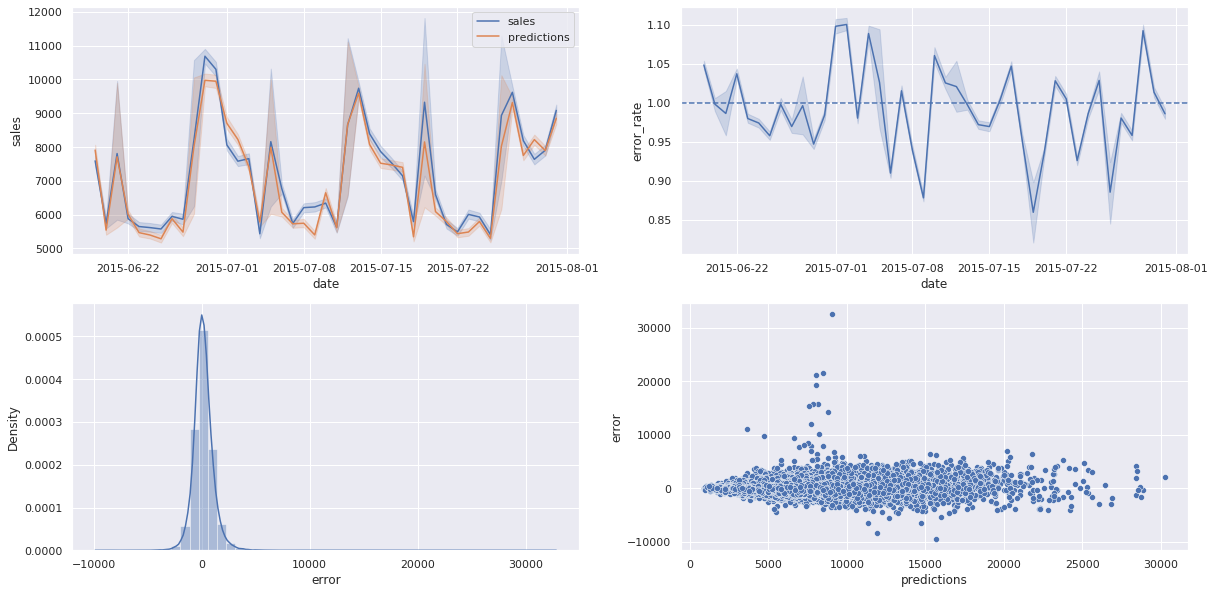

In [92]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='sales')
sns.lineplot(x='date', y='predictions', data=df9, label='predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate', data=df9)
plt.axhline(1, linestyle='--' )

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error']);

# 10 - DEPLOY MODEL TO PRODUCTION

In [100]:
#save trained model
pickle.dump(model_xgb_tunned, open('/home/aleemarino/Desktop/repos/Machine_Learning_Test/model_rossman.pkl','wb'))

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,160864.82812,160587.82873,161141.82752,276.99939,0.06339
1,2,173305.35938,172930.89084,173679.82791,374.46853,0.07645
2,3,263418.78125,262868.69198,263968.87052,550.08927,0.07859
3,4,342394.21875,341527.10495,343261.33255,867.11380,0.08289
4,5,164903.40625,164536.84232,165269.97018,366.56393,0.08182
...,...,...,...,...,...,...
1110,1111,182324.37500,181679.78535,182968.96465,644.58965,0.14202
1111,1112,331575.93750,330557.14440,332594.73060,1018.79310,0.12143
1112,1113,238147.62500,237662.93726,238632.31274,484.68774,0.07561
1113,1114,767702.87500,765350.35462,770055.39538,2352.52038,0.10165
